In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Flatten,Dropout, LSTM, BatchNormalization,SimpleRNN,Input,Conv1D,Conv2D,Concatenate,Activation,MaxPooling1D,Masking,GRU,Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score

import sklearn.metrics as metrics

import tensorflow_addons as tfa
from tensorflow.keras.callbacks import LambdaCallback

from sklearn import preprocessing
import keras

import csv

from keras.callbacks import Callback, ModelCheckpoint
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasClassifier

from keras.callbacks import CSVLogger

In [11]:
df = pd.read_csv(r"C:\Users\brian\Desktop\Python\Mayo Model\Data_outcome_deidentified.csv", header=0)
df.info()
df.drop(['POST','PRE','causeofdeath','primcauseofdeath','death.info','numdisvessels','maxlesionlength', 'wposttimi', 'numbms','numdes', 'numstents', 'maxdevdiameter', 'maxdevlength','otherventsupport\nYes:1 \nNo:0'],axis=1,inplace=True)
effect = ['Inhospital mortality\nYes:1\nNo:0','Mortality 6 months\nYes:1\nNo:0', 'Mortality 1 yr\nYes:1\nNo:0','Mortality 2 yr\nYes:1\nNo:0', 'Mortality 5yr\nYes:1\nNo:0','Time from PCI to Stroke_6mo', 'Time from PCI to Stroke_1yr','Time from PCI to Stroke_2yr', 'Time from PCI to Stroke_5yr']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12731 entries, 0 to 12730
Columns: 179 entries, gender
Male:1
Female:0 to POST
dtypes: float64(1), int64(173), object(5)
memory usage: 17.4+ MB


C:\Users\brian\AppData\Local\Temp\ipykernel_4192\2514652973.py:1: DtypeWarning: Columns (172) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\brian\Desktop\Python\Mayo Model\Data_outcome_deidentified.csv", header=0)


In [23]:
#organizes the data for plotting features
newdf = df.drop(effect, axis=1)
zeroData = []
oneData = []
labels = []
for i in newdf:
    zeroData.append(newdf[i].value_counts()[0])
    oneData.append(newdf[i].value_counts()[1])
    labels.append(i)

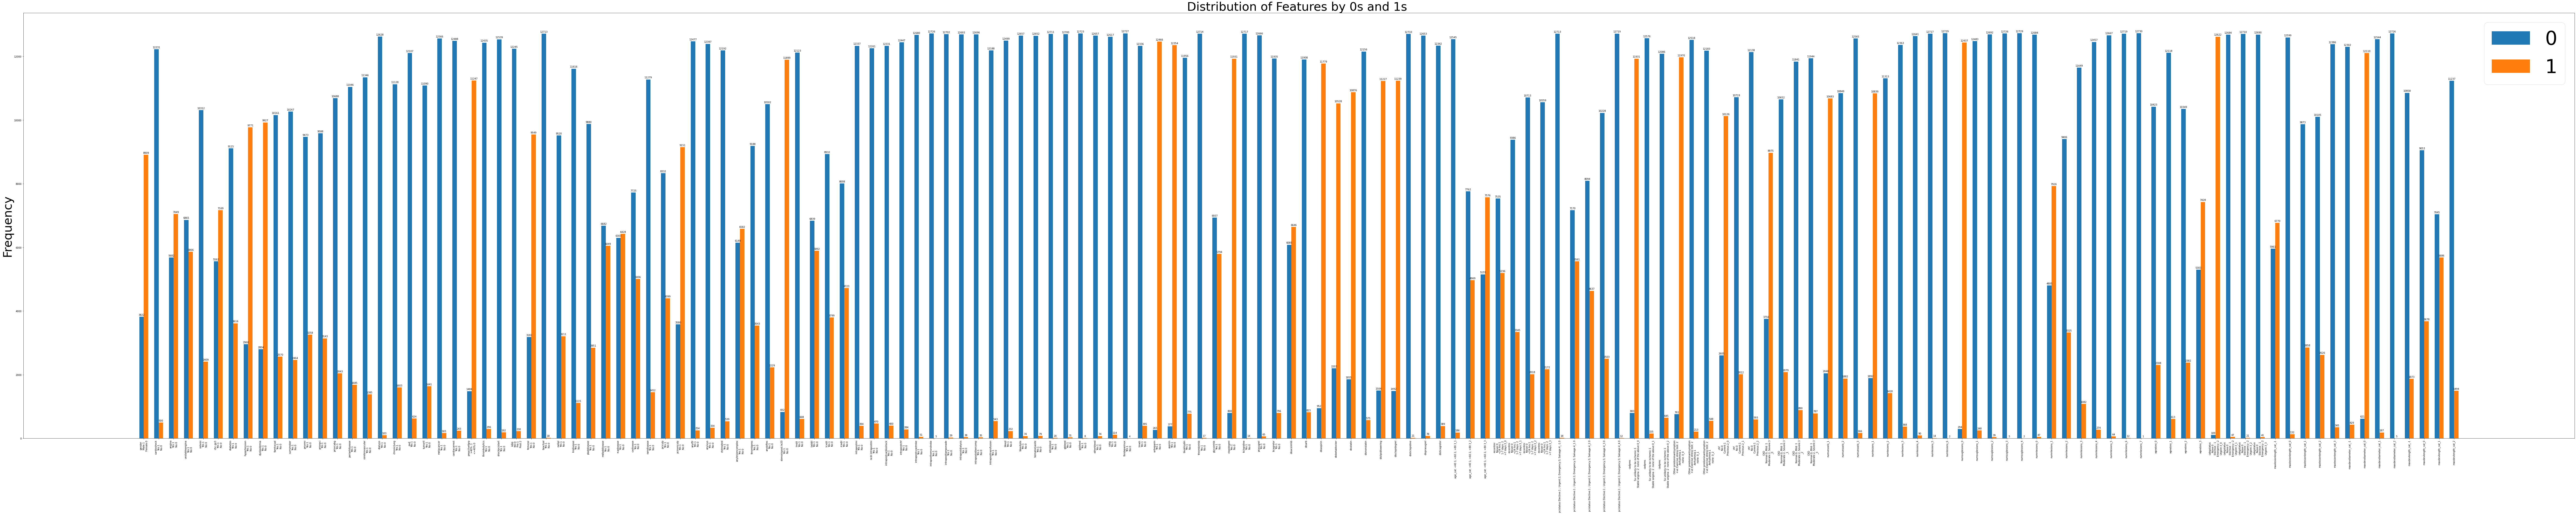

In [118]:
#Plots the distribution of features
from matplotlib.ft2font import VERTICAL
from matplotlib.pyplot import figure


x = np.arange(len(labels))
width = .3

fig, ax = plt.subplots()
fig.set_size_inches(150,30)
rects1 = ax.bar(x - width/2, zeroData, width, label='0')
rects2 = ax.bar(x + width/2, oneData, width, label='1')

ax.set_ylabel('Frequency', fontsize=50)
ax.set_title('Distribution of Features by 0s and 1s ',fontsize=50)
ax.set_xticks(x, labels, rotation=90)
ax.legend(prop={'size':80})

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

x1,x2,y1,y2 = plt.axis()
#plt.axis((x1,x2,y1 - 3000 ,y2 + 3000))
plt.savefig('plot.jpg',bbox_inches='tight', dpi=100)
#plt.show()

In [13]:
#organizes the data for plotting target classes
newdf = df[effect]
zeroData = []
oneData = []
negativeData = []
labels = effect
for i in range(9):
    zeroData.append(df[effect[i]].value_counts()[0])
    oneData.append(df[effect[i]].value_counts()[1])
    if i != 0:
        negativeData.append(df[effect[i]].value_counts()[-1])
    else:
        negativeData.append(0)

In [17]:
print(negativeData)

[0, 868, 1618, 3108, 6371, 1532, 2506, 4323, 8397]


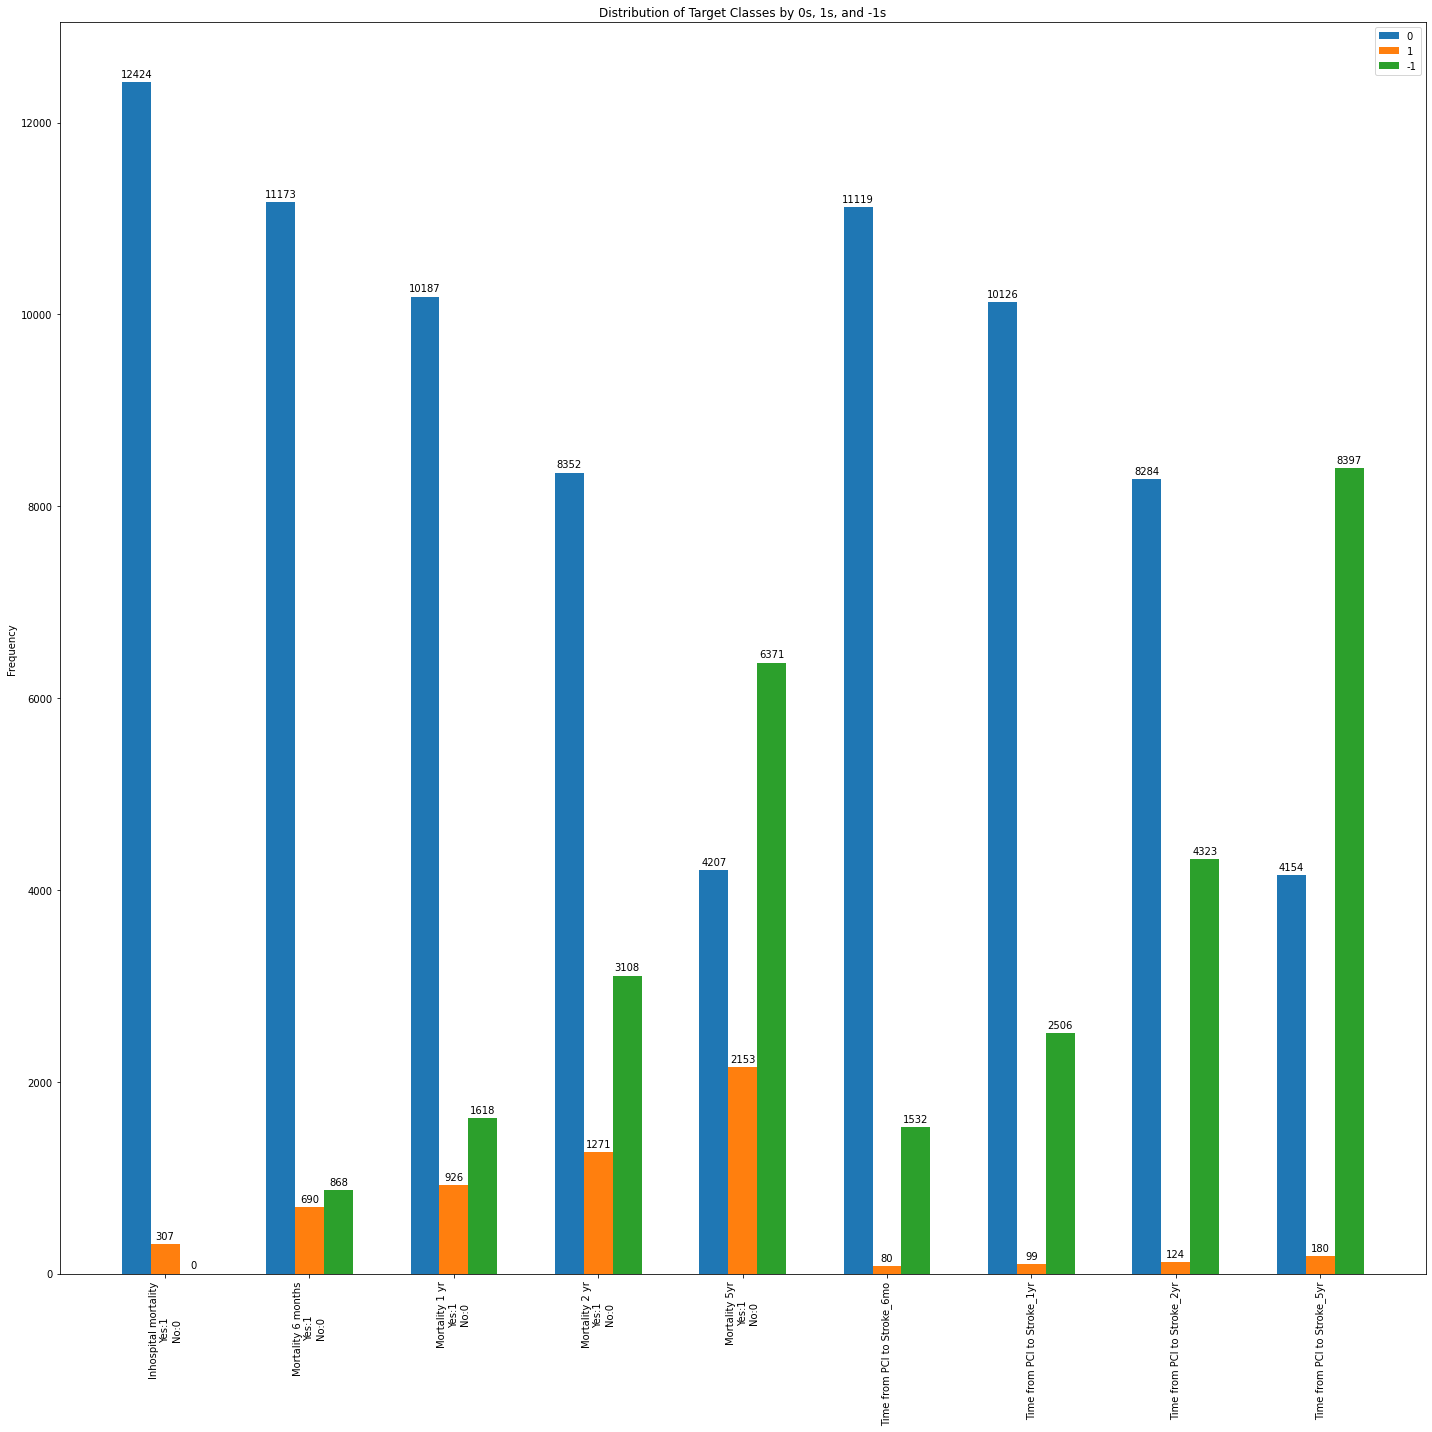

In [29]:
#Plots the distribution of target classes
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(20,20)
rects1 = ax.bar(x - width, zeroData, width, label='0')
rects2 = ax.bar(x, oneData, width, label='1')
rects3 = ax.bar(x + width, negativeData, width, label='-1')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Target Classes by 0s, 1s, and -1s')
ax.set_xticks(x, labels,rotation=90)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.savefig('plot.jpg',bbox_inches='tight', dpi=100)
plt.show()

In [11]:
def f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [12]:
def buildModel(time_steps=1691, n_features=157):

    """The branch dealing with the EHR Data"""
    demo_in =Input(shape=(n_features,), name='Demo 1') 
    dense1 = Dense(n_features, activation='relu')(demo_in)
    dense2 = Dropout(0.25)(dense1)

    dense2 = Dense(128, activation='relu')(dense2)
    dense2 = Dropout(0.25)(dense2) 

    hidden = Dense(128, activation='relu',name='dense1')(dense2)
    
    drop1 = Dropout(0.25)(hidden)

    hidden2 = Dense(1, activation='sigmoid',name='output2')(drop1)
    
    #Building the Model
    model = tf.keras.Model(
        inputs = [demo_in],             
        outputs=hidden2)
    print("Compiling the Model with optimizers and Metrics")
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-4)
    metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(curve= 'ROC'),
    f1
    ]

    model.compile(loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits= False),metrics = metrics,optimizer = opt)

    return model 

In [13]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [14]:
n_features=157

callback_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
callback_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

tf.config.run_functions_eagerly(True)

In [15]:
tf.data.experimental.enable_debug_mode()
csv_files = [r"C:\Users\brian\Desktop\Python\Mayo Model\log0.csv",r"C:\Users\brian\Desktop\Python\Mayo Model\log1.csv",r"C:\Users\brian\Desktop\Python\Mayo Model\log2.csv",r"C:\Users\brian\Desktop\Python\Mayo Model\log3.csv",r"C:\Users\brian\Desktop\Python\Mayo Model\log4.csv",r"C:\Users\brian\Desktop\Python\Mayo Model\log5.csv",r"C:\Users\brian\Desktop\Python\Mayo Model\log6.csv",r"C:\Users\brian\Desktop\Python\Mayo Model\log7.csv",r"C:\Users\brian\Desktop\Python\Mayo Model\log8.csv"]


In [18]:
models=[]
preds_variable=[]
test_variable = []
train_variable = []

In [35]:
count = 0
feature_num = 156
for e in effect:
    print(e)
    csv_logger = CSVLogger(csv_files[count], append=False, separator=',')
    X= df[df[e]>-1]
    
    if(e =='Mortality 1 yr\nYes:1\nNo:0'):
        X = X.drop('Mortality 6 months\nYes:1\nNo:0', axis=1)
        feature_num -= 1
    elif(e =='Mortality 2 yr\nYes:1\nNo:0' ):
        X = X.drop(['Mortality 6 months\nYes:1\nNo:0','Mortality 1 yr\nYes:1\nNo:0'], axis=1)
        feature_num -= 2
    elif(e =='Mortality 5yr\nYes:1\nNo:0'):
        X = X.drop(['Mortality 6 months\nYes:1\nNo:0','Mortality 1 yr\nYes:1\nNo:0', 'Mortality 2 yr\nYes:1\nNo:0'], axis=1)
        feature_num -= 3
    if(e =='Time from PCI to Stroke_1yr'):
        X = X.drop('Time from PCI to Stroke_6mo', axis=1)
        feature_num -= 1
    elif(e =='Time from PCI to Stroke_2yr' ):
        X = X.drop(['Time from PCI to Stroke_6mo','Time from PCI to Stroke_1yr'], axis=1)
        feature_num -= 2
    elif(e =='Time from PCI to Stroke_5yr'):
        X = X.drop(['Time from PCI to Stroke_6mo','Time from PCI to Stroke_1yr', 'Time from PCI to Stroke_2yr'], axis=1)
        feature_num -= 3

    y= X[e]

    if (e == 'Inhospital mortality\nYes:1\nNo:0'):
        X = X.drop(effect,axis=1)
    elif (e == 'Mortality 6 months\nYes:1\nNo:0'):
        X = X.drop(effect,axis=1)
    elif(e =='Mortality 1 yr\nYes:1\nNo:0'):
        X = X.drop(['Inhospital mortality\nYes:1\nNo:0', 'Mortality 1 yr\nYes:1\nNo:0','Mortality 2 yr\nYes:1\nNo:0', 'Mortality 5yr\nYes:1\nNo:0','Time from PCI to Stroke_6mo', 'Time from PCI to Stroke_1yr','Time from PCI to Stroke_2yr', 'Time from PCI to Stroke_5yr'], axis=1)
    elif(e =='Mortality 2 yr\nYes:1\nNo:0' ):
        X = X.drop(['Inhospital mortality\nYes:1\nNo:0','Mortality 2 yr\nYes:1\nNo:0', 'Mortality 5yr\nYes:1\nNo:0','Time from PCI to Stroke_6mo', 'Time from PCI to Stroke_1yr','Time from PCI to Stroke_2yr', 'Time from PCI to Stroke_5yr'], axis=1)
    elif(e =='Mortality 5yr\nYes:1\nNo:0'):
        X = X.drop(['Inhospital mortality\nYes:1\nNo:0', 'Mortality 5yr\nYes:1\nNo:0','Time from PCI to Stroke_6mo', 'Time from PCI to Stroke_1yr','Time from PCI to Stroke_2yr', 'Time from PCI to Stroke_5yr'], axis=1)
    elif(e == 'Time from PCI to Stroke_6mo'):
        X = X.drop(effect,axis=1)
    elif(e =='Time from PCI to Stroke_1yr'):
        X = X.drop(['Inhospital mortality\nYes:1\nNo:0','Mortality 6 months\nYes:1\nNo:0', 'Mortality 1 yr\nYes:1\nNo:0','Mortality 2 yr\nYes:1\nNo:0', 'Mortality 5yr\nYes:1\nNo:0', 'Time from PCI to Stroke_1yr','Time from PCI to Stroke_2yr', 'Time from PCI to Stroke_5yr'], axis=1)
    elif(e =='Time from PCI to Stroke_2yr' ):
        X = X.drop(['Inhospital mortality\nYes:1\nNo:0','Mortality 6 months\nYes:1\nNo:0', 'Mortality 1 yr\nYes:1\nNo:0','Mortality 2 yr\nYes:1\nNo:0', 'Mortality 5yr\nYes:1\nNo:0','Time from PCI to Stroke_2yr', 'Time from PCI to Stroke_5yr'], axis=1)
    elif(e =='Time from PCI to Stroke_5yr'):
        X = X.drop(['Inhospital mortality\nYes:1\nNo:0','Mortality 6 months\nYes:1\nNo:0', 'Mortality 1 yr\nYes:1\nNo:0','Mortality 2 yr\nYes:1\nNo:0', 'Mortality 5yr\nYes:1\nNo:0', 'Time from PCI to Stroke_5yr'], axis=1)
    
    #print(y.iloc[:100])
    X_train,X_test = X.iloc[:len(X)//2,:],X.iloc[len(X)//2:,:]
    y_train,y_test = y.iloc[:len(y)//2],y.iloc[len(y)//2:]
    print(X_test)

Inhospital mortality
Yes:1
No:0
       gender\nMale:1\nFemale:0  cardioshock\nYes:1 \nNo:0  \
6365                          1                          0   
6366                          1                          0   
6367                          1                          0   
6368                          1                          0   
6369                          1                          0   
...                         ...                        ...   
12726                         0                          0   
12727                         1                          0   
12728                         1                          0   
12729                         1                          0   
12730                         1                          0   

       angina\nYes:1 \nNo:0  unstableangina\nYes:1 \nNo:0  \
6365                      0                             0   
6366                      0                             0   
6367                      0             

In [19]:
count = 0
feature_num = 156
for e in effect:
    print(e)
    csv_logger = CSVLogger(csv_files[count], append=False, separator=',')
    X= df[df[e]>-1]
    
    if(e =='Mortality 1 yr\nYes:1\nNo:0'):
        X = X.drop('Mortality 6 months\nYes:1\nNo:0', axis=1)
        feature_num -= 1
    elif(e =='Mortality 2 yr\nYes:1\nNo:0' ):
        X = X.drop(['Mortality 6 months\nYes:1\nNo:0','Mortality 1 yr\nYes:1\nNo:0'], axis=1)
        feature_num -= 2
    elif(e =='Mortality 5yr\nYes:1\nNo:0'):
        X = X.drop(['Mortality 6 months\nYes:1\nNo:0','Mortality 1 yr\nYes:1\nNo:0', 'Mortality 2 yr\nYes:1\nNo:0'], axis=1)
        feature_num -= 3
    if(e =='Time from PCI to Stroke_1yr'):
        X = X.drop('Time from PCI to Stroke_6mo', axis=1)
        feature_num -= 1
    elif(e =='Time from PCI to Stroke_2yr' ):
        X = X.drop(['Time from PCI to Stroke_6mo','Time from PCI to Stroke_1yr'], axis=1)
        feature_num -= 2
    elif(e =='Time from PCI to Stroke_5yr'):
        X = X.drop(['Time from PCI to Stroke_6mo','Time from PCI to Stroke_1yr', 'Time from PCI to Stroke_2yr'], axis=1)
        feature_num -= 3

    y= X[e]

    if (e == 'Inhospital mortality\nYes:1\nNo:0'):
        X = X.drop(effect,axis=1)
    elif (e == 'Mortality 6 months\nYes:1\nNo:0'):
        X = X.drop(effect,axis=1)
    elif(e =='Mortality 1 yr\nYes:1\nNo:0'):
        X = X.drop(['Inhospital mortality\nYes:1\nNo:0', 'Mortality 1 yr\nYes:1\nNo:0','Mortality 2 yr\nYes:1\nNo:0', 'Mortality 5yr\nYes:1\nNo:0','Time from PCI to Stroke_6mo', 'Time from PCI to Stroke_1yr','Time from PCI to Stroke_2yr', 'Time from PCI to Stroke_5yr'], axis=1)
    elif(e =='Mortality 2 yr\nYes:1\nNo:0' ):
        X = X.drop(['Inhospital mortality\nYes:1\nNo:0','Mortality 2 yr\nYes:1\nNo:0', 'Mortality 5yr\nYes:1\nNo:0','Time from PCI to Stroke_6mo', 'Time from PCI to Stroke_1yr','Time from PCI to Stroke_2yr', 'Time from PCI to Stroke_5yr'], axis=1)
    elif(e =='Mortality 5yr\nYes:1\nNo:0'):
        X = X.drop(['Inhospital mortality\nYes:1\nNo:0', 'Mortality 5yr\nYes:1\nNo:0','Time from PCI to Stroke_6mo', 'Time from PCI to Stroke_1yr','Time from PCI to Stroke_2yr', 'Time from PCI to Stroke_5yr'], axis=1)
    elif(e == 'Time from PCI to Stroke_6mo'):
        X = X.drop(effect,axis=1)
    elif(e =='Time from PCI to Stroke_1yr'):
        X = X.drop(['Inhospital mortality\nYes:1\nNo:0','Mortality 6 months\nYes:1\nNo:0', 'Mortality 1 yr\nYes:1\nNo:0','Mortality 2 yr\nYes:1\nNo:0', 'Mortality 5yr\nYes:1\nNo:0', 'Time from PCI to Stroke_1yr','Time from PCI to Stroke_2yr', 'Time from PCI to Stroke_5yr'], axis=1)
    elif(e =='Time from PCI to Stroke_2yr' ):
        X = X.drop(['Inhospital mortality\nYes:1\nNo:0','Mortality 6 months\nYes:1\nNo:0', 'Mortality 1 yr\nYes:1\nNo:0','Mortality 2 yr\nYes:1\nNo:0', 'Mortality 5yr\nYes:1\nNo:0','Time from PCI to Stroke_2yr', 'Time from PCI to Stroke_5yr'], axis=1)
    elif(e =='Time from PCI to Stroke_5yr'):
        X = X.drop(['Inhospital mortality\nYes:1\nNo:0','Mortality 6 months\nYes:1\nNo:0', 'Mortality 1 yr\nYes:1\nNo:0','Mortality 2 yr\nYes:1\nNo:0', 'Mortality 5yr\nYes:1\nNo:0', 'Time from PCI to Stroke_5yr'], axis=1)
    
    #print(y.iloc[:100])
    X_train,X_test = X.iloc[:len(X)//2,:],X.iloc[len(X)//2:,:]
    y_train,y_test = y.iloc[:len(y)//2],y.iloc[len(y)//2:]
    model = buildModel(time_steps = 1691, n_features=156) 
    history = model.fit([X_train], y_train, batch_size=64, validation_split = 0.2, epochs = 100,
                            callbacks=[callback_stopping, callback_scheduler, csv_logger],shuffle=True)
    models.append(model)
    preds = model.predict([X_test])
    preds_train = model.predict([X_train])
    preds_test = model.predict([X_test])
    train_variable.append(preds_train)
    test_variable.append(preds_test)
    preds_variable.append(preds)
    count = count + 1

Inhospital mortality
Yes:1
No:0
Compiling the Model with optimizers and Metrics
Epoch 1/100
80/80 [==============================] - 3s 33ms/step - loss: 0.0507 - fn: 120.0000 - fp: 544.0000 - tn: 4417.0000 - tp: 11.0000 - precision: 0.0198 - recall: 0.0840 - auc_9: 0.5470 - f1: 0.0248 - val_loss: 0.0086 - val_fn: 16.0000 - val_fp: 0.0000e+00 - val_tn: 1257.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc_9: 0.6696 - val_f1: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
80/80 [==============================] - 3s 32ms/step - loss: 0.0106 - fn: 131.0000 - fp: 0.0000e+00 - tn: 4961.0000 - tp: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc_9: 0.7637 - f1: 0.0000e+00 - val_loss: 0.0063 - val_fn: 16.0000 - val_fp: 0.0000e+00 - val_tn: 1257.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc_9: 0.8162 - val_f1: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/100
80/80 [==============================] - 3s 32ms/step - l

In [18]:
count = 0
for e in effect:
    print(e)
    csv_logger = CSVLogger(csv_files[count], append=False, separator=',')
    X= df[df[e]>-1]
    
    if(e =='Mortality 1 yr\nYes:1\nNo:0'):
        X=X[X['Mortality 6 months\nYes:1\nNo:0']!=1]
    elif(e =='Mortality 2 yr\nYes:1\nNo:0' ):
        X=X[(X['Mortality 6 months\nYes:1\nNo:0']!=1) & (X['Mortality 1 yr\nYes:1\nNo:0']!=1)]
    elif(e =='Mortality 5 yr\nYes:1\nNo:0'):
        X = X[(X['Mortality 6 months\nYes:1\nNo:0']!=1) & (X['Mortality 1 yr\nYes:1\nNo:0']!=1) & (X['Mortality 2 yr\nYes:1\nNo:0']!=1) ]
    if(e =='Time from PCI to Stroke_1yr'):
        X=X[X['Time from PCI to Stroke_6mo']!=1]
    elif(e =='Time from PCI to Stroke_2yr' ):
        X=X[(X['Time from PCI to Stroke_6mo']!=1) & (X['Time from PCI to Stroke_1yr']!=1)]
    elif(e =='Time from PCI to Stroke_5yr'):
        X = X[(X['Time from PCI to Stroke_6mo']!=1) & (X['Time from PCI to Stroke_1yr']!=1) & (X['Time from PCI to Stroke_2yr']!=1) ]


    y= X[e]
    X=X.drop(effect,axis=1)
    #print(y.iloc[:100])
    X_train,X_test = X.iloc[:len(X)//2,:],X.iloc[len(X)//2:,:]
    y_train,y_test = y.iloc[:len(y)//2],y.iloc[len(y)//2:]
    model = buildModel(time_steps = 1691, n_features=156) 
    history = model.fit([X_train], y_train, batch_size=64, validation_split = 0.2, epochs = 100,
                            callbacks=[callback_stopping, callback_scheduler, csv_logger],shuffle=True)
    models.append(model)
    preds = model.predict([X_test])
    preds_train = model.predict([X_train])
    preds_test = model.predict([X_test])
    train_variable.append(preds_train)
    test_variable.append(preds_test)
    preds_variable.append(preds)
    count = count + 1

Inhospital mortality
Yes:1
No:0
Compiling the Model with optimizers and Metrics
Epoch 1/100
79/80 [============================>.] - ETA: 0s - loss: 0.0383 - fn: 403.0000 - fp: 44.0000 - tn: 4606.0000 - tp: 3.0000 - precision: 0.0638 - recall: 0.0074 - auc_12: 0.4953 - f1: 0.0084

ValueError: Data cardinality is ambiguous:
  x sizes: 1273
  y sizes: 464
Make sure all arrays contain the same number of samples.

In [ ]:
print()

In [26]:
train_data = []
temp = []

In [33]:
temp = []
count = 0;
for e in range(9):
  temp.append([])
  counter = 0
  for i in test_variable[e]:
    temp[e].append(i[0])
    counter = counter + 1
  while (counter < 6366):
    temp[e].append(0)
    counter = counter + 1

In [34]:
train_data = pd.DataFrame()
count = 0
for e in effect:
  train_data[e] = temp[count]
  count = count + 1

train_data.to_csv(r"C:\Users\brian\Desktop\Python\Mayo Model\test_varaible.csv")